In [1]:
!git clone https://github.com/dayeonki/askqe

fatal: destination path 'askqe' already exists and is not an empty directory.


In [4]:
import sys
REPO_PATH = "askqe"

sys.path.insert(0, REPO_PATH)
sys.path.insert(0, f"{REPO_PATH}/QG/code")
sys.path.insert(0, f"{REPO_PATH}/QA/code")
sys.path.insert(0, f"{REPO_PATH}/biomqm/askqe")
sys.path.insert(0, f"{REPO_PATH}/evaluation/string-comparison")

In [5]:
import os
os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn"

In [1]:
!pip install -q vllm

In [3]:
!pip install sacrebleu

In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

#Loading data

In [7]:
from QG.code.prompt import nli as qg_prompt_template
from QA.code.prompt import qa_prompt as qa_prompt_template
from biomqm.askqe.prompt import atomic_fact_prompt as atomic_fact_prompt_template

In [8]:
import json
import os
import glob

LIMIT = None # change to minimize data or None


def calculate_mqm_score(errors):
    weights = {"Minor": 1, "Major": 5, "Critical": 25}
    score_penalty = 0
    for error in errors:
        severity = error.get("severity")
        score_penalty += weights.get(severity, 0)
    return max(0, 100 - score_penalty)

def get_max_severity(errors):
    if not errors:
        return "No Error"
    severities = [e.get("severity") for e in errors]
    if "Critical" in severities:
        return "Critical"
    if "Major" in severities:
        return "Major"
    return "Minor"

def load_biomqm_data(file_path, limit=None):
    data_entries = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if limit and i >= limit:
                    break
                item = json.loads(line)

                # BIOMQM structure: src, tgt, bt_tgt, errors_tgt
                entry = {
                    'id': item.get('doc_id', f'doc_{i}'),
                    'source': item['src'],
                    'target': item['tgt'],
                    'backtranslation': item.get('bt_tgt', ''),
                    'errors': item.get('errors_tgt', []),
                    'lang': item.get('lang_tgt', ''),
                    'mqm_score': calculate_mqm_score(item.get('errors_tgt', [])),
                    'severity': get_max_severity(item.get('errors_tgt', []))
                }
                data_entries.append(entry)

        print(f"Loaded {len(data_entries)} entries from BIOMQM successfully.")
        return data_entries
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return []


BIOMQM_FILE = f"{REPO_PATH}/biomqm/dev_with_backtranslation.jsonl"
dataset = load_biomqm_data(BIOMQM_FILE, limit=LIMIT)


Loaded 5216 entries from BIOMQM successfully.


#Cleaning data

In [9]:
import pandas as pd

def term_in_data(df):
    valid_rows = []

    for row in df:
        tgt = row.get('target', '')
        src = row.get('source', '')
        errors = row.get('errors', [])
        is_row_clean = True

        for error in errors:
            term = error.get('term', '')

            if term:
                if term not in tgt and term not in src:
                    is_row_clean = False
                    break

        if is_row_clean:
            valid_rows.append(row)

    return valid_rows


print("SHAPE BEFORE:", len(dataset))
dataset_clean = term_in_data(dataset)
print("SHAPE AFTER:", len(dataset_clean))

SHAPE BEFORE: 5216
SHAPE AFTER: 5000


#Model init

In [10]:
from vllm import LLM, SamplingParams

MODEL_ID = "Qwen/Qwen3-4B-Instruct-2507"

llm = LLM(
    model=MODEL_ID,
    dtype="half",
    max_model_len=2048,
    gpu_memory_utilization=0.60,
    #quantization="awq",
    seed=0,
    enable_prefix_caching=True,
    disable_log_stats=True,
    # enforce_eager=False,
)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

INFO 02-12 21:33:21 [utils.py:261] non-default args: {'dtype': 'half', 'max_model_len': 2048, 'enable_prefix_caching': True, 'gpu_memory_utilization': 0.6, 'disable_log_stats': True, 'model': 'Qwen/Qwen3-4B-Instruct-2507'}
INFO 02-12 21:33:24 [model.py:541] Resolved architecture: Qwen3ForCausalLM
WARNING 02-12 21:33:24 [model.py:1885] Casting torch.bfloat16 to torch.float16.
INFO 02-12 21:33:24 [model.py:1561] Using max model len 2048
INFO 02-12 21:33:24 [scheduler.py:226] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 02-12 21:33:24 [vllm.py:624] Asynchronous scheduling is enabled.
INFO 02-12 21:34:24 [llm.py:343] Supported tasks: ['generate']


In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)

SAMPLING_PARAMS = SamplingParams(
    temperature=0,
    max_tokens=1024
)


def generate_text_batch(prompts, sampling_params=SAMPLING_PARAMS):
    formatted_prompts = []
    for p in prompts:
        messages = [{"role": "user", "content": p}]
        formatted = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        formatted_prompts.append(formatted)

    outputs = llm.generate(formatted_prompts, sampling_params)

    generated_texts = []
    for output in outputs:
        text = output.outputs[0].text.strip()
        if not text.endswith("]"):
            text = text + "]"
        if not text.startswith("["):
            text = "[" + text
        generated_texts.append(text)

    return generated_texts

def parse_list_output(text):
    """Parses a string representation of a list into a Python list."""
    import ast
    try:
        start = text.find('[')
        end = text.rfind(']') + 1
        if start != -1 and end != -1:
            candidate = text[start:end]
            return ast.literal_eval(candidate)
        return []
    except:
        return []


#AskQE pipeline

In [12]:
import re
import json

# =============================================================================
# PHASE 1: Multi-Judge (Source vs Target)
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 1: Multi-Judge (Source vs Target)")
print("=" * 60)

JUDGE_PROMPT = """You are an expert translation quality evaluator (STRICT MODE).

Task: Compare the semantic meaning of the Source Sentence and the Target Sentence (Translation).
You MUST be conservative: if you are not sure the meaning is identical, do NOT output "NONE".
When uncertain between two labels, choose the MORE SEVERE one.

Source Sentence: {source}
Target Sentence: {target}

How to judge (follow in this order):
1) Extract from the Source the key meaning units: entities, numbers/units, negation/polarity, modality (must/should/can), time/tense, and the main predicate + roles (who did what to whom).
2) Check each unit against the Target Translation.

Decision rules:
- CRITICAL if ANY of these occur:
  a) Expansion (Impact): any added claim/detail that introduces new meaning (not just obvious/implicit filler).
  b) Omission: any missing word/phrase that removes a meaning unit or changes what is asserted.
  c) Alteration: antonym, polarity/negation flip, different actor/object, different time, different condition, different outcome.
  d) Numbers/units/dates/names change or mismatch.
  e) Safety risk: the target could change an instruction, warning, permission, or prohibition.

- MAJOR if the core topic remains but an important detail/constraint is changed or blurred (scope, intensity, condition, timeframe, responsibility), without a full contradiction.

- MINOR ONLY if the difference is exclusively one (or more) of these minor perturbations and does NOT change truth conditions:
  • Spelling (1–2 words)
  • Word order
  • Synonym (same meaning, no register shift)
  • Intensifier (small emphasis change, no change to factual claim)
  • Expansion (No Impact): adds only contextually obvious/implicit info, no new proposition

- NONE only if semantically equivalent AND no meaning units are added/omitted/altered.

Output JSON only:
{{"classification":"NONE|MINOR|MAJOR|CRITICAL","reason":"brief explanation"}}
"""

def parse_llm_judgment(response_text):
    try:
        text = re.sub(r'```json\s*|```', '', response_text).strip()
        start, end = text.find('{'), text.rfind('}') + 1
        return json.loads(text[start:end])
    except:
        return {"error": True}


def calculate_judge_score(classification):
    weights = {"NONE": 0, "MINOR": 1, "MAJOR": 5, "CRITICAL": 25}
    severity = classification.upper()
    score_penalty = weights.get(severity, 25)
    return max(0, 100 - score_penalty)


results = []
for idx, entry in enumerate(dataset_clean):
    results.append({
        "id": entry["id"],
        "source": entry["source"],
        "target": entry.get("target", ""),
        "backtranslation": entry.get("backtranslation", ""),
        "mqm_score": entry.get("mqm_score", None),
        "severity": entry.get("severity", None),
    })

for item in results:
    item['judge_multi_cls'] = None
    item['judge_multi_reason'] = None
    item['judge_multi_score'] = 0

judge_prompts = []
indices_map = []

for i, item in enumerate(results):

    source = item.get('source', '')
    target = item.get('target', '')

    if not source or not target:
        continue

    prompt = JUDGE_PROMPT.format(
        source=source,
        target=target
    )

    judge_prompts.append(prompt)
    indices_map.append(i)

print(f"Running Multi-Judges on {len(judge_prompts)} entries")

JUDGE_PARAMS = SamplingParams(
    temperature=0,
    max_tokens=512
)

llm_responses = generate_text_batch(judge_prompts, JUDGE_PARAMS)

parsing_errors_count = 0
for idx_in_batch, original_index in enumerate(indices_map):
    raw_response = llm_responses[idx_in_batch]
    parsed_result = parse_llm_judgment(raw_response)

    target_item = results[original_index]

    classification = parsed_result.get('classification', '')
    reason = parsed_result.get('reason', '')

    target_item['judge_cls'] = classification
    target_item['judge_reason'] = reason

    if parsed_result.get('error'):
        parsing_errors_count += 1
        target_item['judge_score'] = None
    else:
        target_item['judge_score'] = calculate_judge_score(classification)

print(f"Processing complete. Parsing errors count: {parsing_errors_count}")

output_file = "askqe_results.jsonl"
with open(output_file, 'w') as f:
    for res in results:
        f.write(json.dumps(res) + '\n')

print(f"Results saved to {output_file}")




PHASE 1: Multi-Judge (Source vs Target)
Running Multi-Judges on 5000 entries


Adding requests:   0%|          | 0/5000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/5000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Processing complete. Parsing errors count: 10
Results saved to askqe_results.jsonl


#Scoring & Evaluation

In [13]:
import json
import torch

from utils import (
    f1_score as repo_f1_score,
    exact_match_score as repo_exact_match_score,
    chrf_score as repo_chrf_score,
    bleu_score as repo_bleu_score,
    compare_answers as repo_compare_answers,
    normalize_answer
)

device = "cuda" if torch.cuda.is_available() else "cpu"

output_file = "askqe_results.jsonl"

results = []
lost_cnt = 0
with open(output_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        data = json.loads(line)
        if data.get("target") and data.get("source"):
            results.append(data)
        else:
            lost_cnt += 1

total_records = len(results) + lost_cnt
print(f"Loaded {len(results)} out of {total_records} records from {output_file} (skipped {lost_cnt})")
print("First element example:", results[0] if results else "empty list")

Loaded 5000 out of 5000 records from askqe_results.jsonl (skipped 0)
First element example: {'id': 'doc11', 'source': 'Three cases of cervicofacial NF are presented in this case report.', 'target': 'In diesem Fallbericht werden drei Fälle von zervikofazialem NF vorgestellt.', 'backtranslation': 'This case report presents three cases of cervicofacial NF.', 'mqm_score': 95, 'severity': 'Major', 'judge_multi_cls': None, 'judge_multi_reason': None, 'judge_multi_score': 0, 'judge_cls': 'NONE', 'judge_reason': "The key meaning units are preserved: 'three cases', 'cervicofacial NF', 'presented in this case report'. The Target accurately reflects the Source without addition, omission, alteration, or mismatch in numbers or entities. The translation is semantically equivalent and uses appropriate medical terminology in German.", 'judge_score': 100}


## ASKQE scores using different metrics evaluated on BIOMQM per error severity

###Correlation analysis

In [14]:
import json

output_file = "askqe_results.jsonl"

results = []
with open(output_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        results.append(json.loads(line))

print(f"Loaded {len(results)} records from {output_file}")
print("First element example:", results[0] if results else "empty list")

Loaded 5000 records from askqe_results.jsonl
First element example: {'id': 'doc11', 'source': 'Three cases of cervicofacial NF are presented in this case report.', 'target': 'In diesem Fallbericht werden drei Fälle von zervikofazialem NF vorgestellt.', 'backtranslation': 'This case report presents three cases of cervicofacial NF.', 'mqm_score': 95, 'severity': 'Major', 'judge_multi_cls': None, 'judge_multi_reason': None, 'judge_multi_score': 0, 'judge_cls': 'NONE', 'judge_reason': "The key meaning units are preserved: 'three cases', 'cervicofacial NF', 'presented in this case report'. The Target accurately reflects the Source without addition, omission, alteration, or mismatch in numbers or entities. The translation is semantically equivalent and uses appropriate medical terminology in German.", 'judge_score': 100}


In [15]:
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

print("\n" + "="*50)
print("Correlation Analysis (Kendall's Tau)")
print("="*50)

metrics = {
    "JUDGE": "judge_score"
}
names = []
values = []

print(f"{'Metric':<10} {'Tau':<10} {'P-Value':<10}")
print("-" * 35)

for name, col_name in metrics.items():
    tau, p_value = scipy.stats.kendalltau(df_results[col_name], df_results['mqm_score'], nan_policy='omit')
    names.append(name)
    values.append(tau)
    print(f"{name:<10} {tau:.4f}     {p_value:.4e}")

print("-" * 35)



Correlation Analysis (Kendall's Tau)
Metric     Tau        P-Value   
-----------------------------------
JUDGE      0.2336     2.4391e-80
-----------------------------------


##BT-Score

In [16]:
def save_checkpoint(data, filename):
    print(f"   [Checkpoint] Saving {len(data)} records to {filename}...")
    with open(filename, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    print("   [Checkpoint] Done.")

In [17]:
!pip install -q bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.9 MB/s eta 0:00:00


In [18]:
from bert_score import score as bert_score
import pandas as pd
import scipy.stats

print("Calculating BT-Score...")

_, _, F1_mono = bert_score(
    [r['backtranslation'] for r in results],
    [r['source'] for r in results],
    lang="en",
    rescale_with_baseline=True,
    verbose=True
)

print("Calculating Multi-lingual Score...")
_, _, F1_multi = bert_score(
    [r['target'] for r in results],
    [r['source'] for r in results],
    model_type="bert-base-multilingual-cased",
    verbose=True
)

f1_mono_vals = F1_mono.numpy()
f1_multi_vals = F1_multi.numpy()

for item, s_mono, s_multi in zip(results, f1_mono_vals, f1_multi_vals):
    item['bt_score'] = float(s_mono)
    item['bt_score_multi'] = float(s_multi)

for r in results:
    if 'bt_score' not in r:
        r['bt_score'] = 0.0
        print("WARNING. Some data is missing")
    if 'bt_score_multi' not in r:
        r['bt_score_multi'] = 0.0
        print("WARNING. Some data is missing")

df = pd.DataFrame(results)
tau_mono, p_mono = scipy.stats.kendalltau(df['bt_score'], df['mqm_score'])
tau_multi, p_multi = scipy.stats.kendalltau(df['bt_score_multi'], df['mqm_score'])

print("\n" + "="*50)
print(f"{'Metric':<20} {'Tau':<10} {'P-Value':<10}")
print("-" * 50)
print(f"{'BT-Score (Mono)':<20} {tau_mono:.4f}     {p_mono:.4e}")
print(f"{'BT-Score (Multi)':<20} {tau_multi:.4f}     {p_multi:.4e}")
print("="*50)

save_checkpoint(results, "askqe_results_final.jsonl")

Calculating BT-Score...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/52 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/79 [00:00<?, ?it/s]

done in 13.84 seconds, 361.16 sentences/sec
Calculating Multi-lingual Score...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/58 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/79 [00:00<?, ?it/s]

done in 11.33 seconds, 441.25 sentences/sec

Metric               Tau        P-Value   
--------------------------------------------------
BT-Score (Mono)      0.1064     9.4086e-25
BT-Score (Multi)     0.0235     2.3573e-02
   [Checkpoint] Saving 5000 records to askqe_results_final.jsonl...
   [Checkpoint] Done.


## xCOMET-QE

In [19]:
!pip install -q unbabel-comet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 36.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
vllm 0.15.1 requires protobuf>=6.33.5, but you have protobuf 4.25.8 which is incompatible.
grpcio-reflection 1.78.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 4.25.8 whic

In [20]:
from comet import download_model, load_from_checkpoint
import pandas as pd
import scipy.stats
import torch

print("Loading xCOMET-QE model...")
model_path = download_model("Unbabel/wmt20-comet-qe-da")
model = load_from_checkpoint(model_path)

print("Calculating xCOMET-QE Score...")

comet_data_bt = []
comet_data_multi = []
valid_indices = []

for i, r in enumerate(results):
    if r.get('source') and r.get('backtranslation') and r.get('target'):
        comet_data_bt.append({
            "src": r['source'],
            "mt": r['backtranslation']
        })
        comet_data_multi.append({
            "src": r['source'],
            "mt": r['target']
        })
        valid_indices.append(i)
    else:
        print(f"WARNING. Some data is missing")
        r['xcomet_score'] = 0.0
        r['xcomet_score_multi'] = 0.0

if comet_data_bt:
    gpus = 1 if torch.cuda.is_available() else 0
    output_bt = model.predict(comet_data_bt, batch_size=8, gpus=gpus)
    output_multi = model.predict(comet_data_multi, batch_size=8, gpus=gpus)
    for idx, s_bt, s_multi in zip(valid_indices, output_bt.scores, output_multi.scores):
        results[idx]['xcomet_score'] = float(s_bt)
        results[idx]['xcomet_score_multi'] = float(s_multi)

df = pd.DataFrame(results)

tau_bt, p_bt = scipy.stats.kendalltau(df['xcomet_score'], df['mqm_score'])
tau_multi, p_multi = scipy.stats.kendalltau(df['xcomet_score_multi'], df['mqm_score'])

print("\n" + "="*50)
print(f"{'Metric':<20} {'Tau':<10} {'P-Value':<10}")
print("-" * 50)
print(f"{'xCOMET (BT)':<20} {tau_bt:.4f}     {p_bt:.4e}")
print(f"{'xCOMET (Multi)':<20} {tau_multi:.4f}     {p_multi:.4e}") # Вывод
print("="*50)

save_checkpoint(results, "askqe_results_final.jsonl")

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loading xCOMET-QE model...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/479 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.6.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt20-comet-qe-da/snapshots/2e7ffc84fb67d99cf92506611766463bb9230cfb/checkpoints/model.ckpt`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly ut

Calculating xCOMET-QE Score...
WARNING. Some data is missing
WARNING. Some data is missing
WARNING. Some data is missing


Predicting DataLoader 0: 100%|██████████| 625/625 [00:44<00:00, 13.92it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 625/625 [00:45<00:00, 13.85it/s]



Metric               Tau        P-Value   
--------------------------------------------------
xCOMET (BT)          0.2157     2.5474e-96
xCOMET (Multi)       0.3063     4.2517e-192
   [Checkpoint] Saving 5000 records to askqe_results_final.jsonl...
   [Checkpoint] Done.


##GMM

In [21]:
df_results = pd.DataFrame(results)

print(f"BEFORE: {len(df_results)}")
df_results = df_results.dropna(subset=['judge_score'])
print(f"AFTER: {len(df_results)}")

BEFORE: 5000
AFTER: 4990


Judge Treshold

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b9bdcd27e20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/numpy.libs/libscipy_openblas64_-99b71e


--- GMM Decision Accuracy ---
JUDGE: 77.35%  (Threshold > 95) | Acc μ: 99.833, Rej μ: 77.525
BERTScore: 76.69%  (GMM) | Acc μ: 0.818, Rej μ: 0.095
BERTScore (Multi): 50.26%  (GMM) | Acc μ: 0.839, Rej μ: 0.767
COMET: 73.51%  (GMM) | Acc μ: 0.544, Rej μ: 0.226
COMET (Multi): 75.15%  (GMM) | Acc μ: 0.488, Rej μ: -0.001


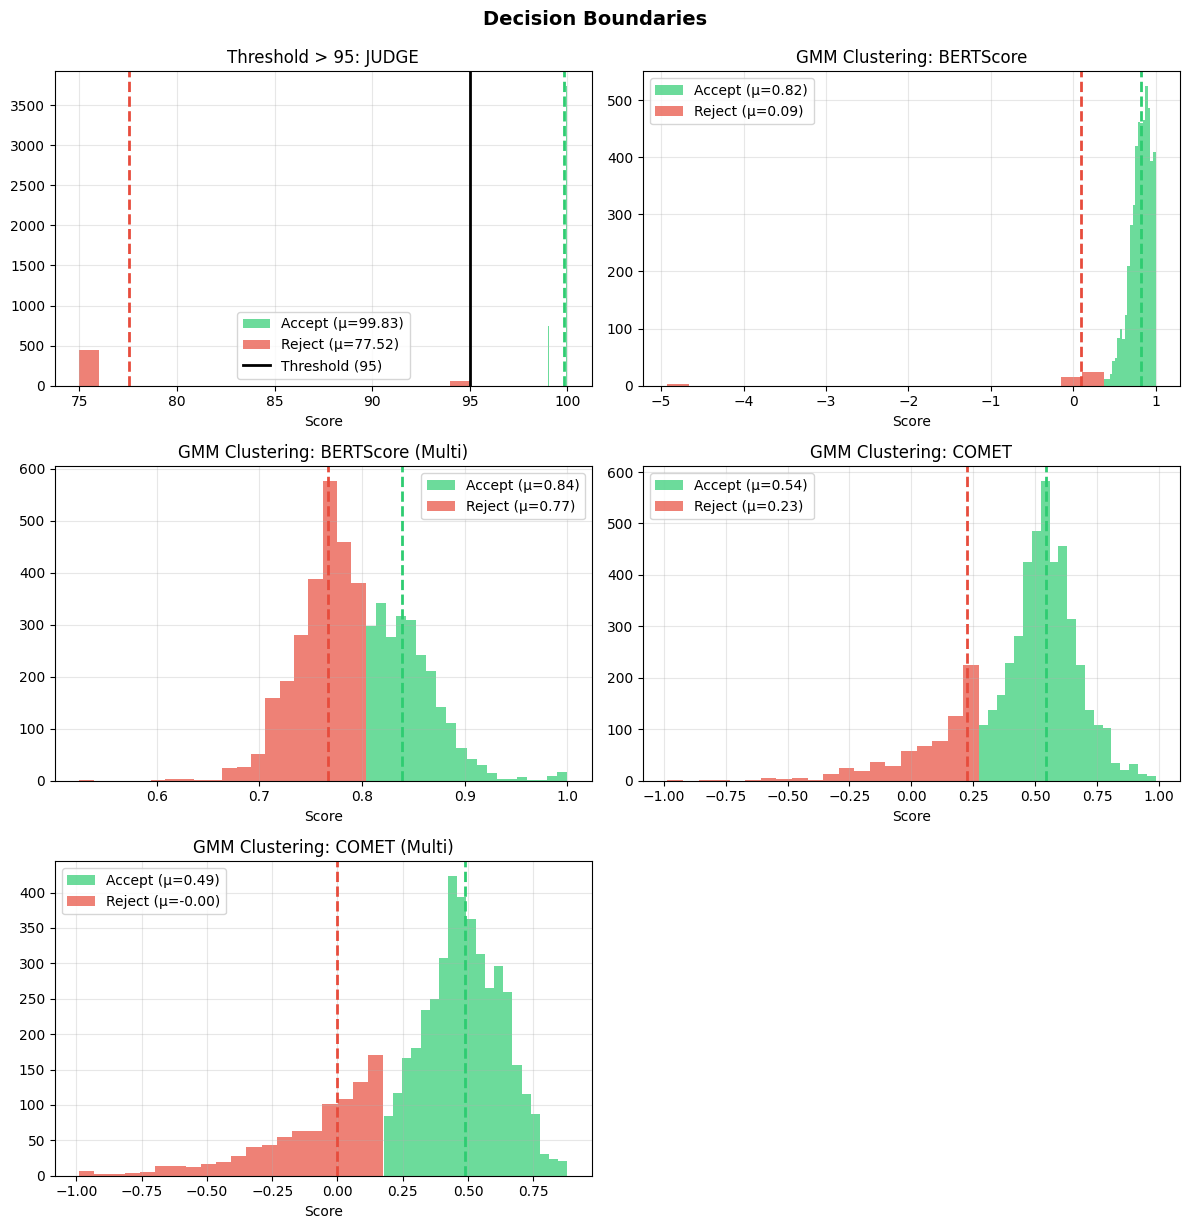

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def get_human_labels(df):
    """Generates ground truth booleans (Accept=True) from severity strings."""
    valid_severities = {'no error', 'neutral', 'minor', 'none'}
    return df['severity'].astype(str).str.lower().isin(valid_severities)

def fit_gmm(data):
    """Fits a 2-component GMM and returns the model, means, and cluster assignments."""
    X = data.values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=42).fit(X)

    means = gmm.means_.flatten()
    accept_idx = np.argmax(means)  # The cluster with higher score is "Accept"
    labels = gmm.predict(X)

    return means, accept_idx, labels

def evaluate_metric(df, col, name):
    """Calculates decision accuracy for a single metric."""

    if col == 'judge_score':
        # Жесткий порог
        pred_accept = df[col] > 95
        title_suffix = " (Threshold > 95)"

        # Считаем средние для статистики
        acc_mean = df[col][pred_accept].mean() if pred_accept.any() else 0
        rej_mean = df[col][~pred_accept].mean() if (~pred_accept).any() else 0

    else:
        # Автоматический GMM
        means, accept_idx, labels = fit_gmm(df[col])
        pred_accept = (labels == accept_idx)
        title_suffix = " (GMM)"

        acc_mean = means[accept_idx]
        rej_mean = means[1-accept_idx]

    human_accept = get_human_labels(df)
    accuracy = np.mean(pred_accept == human_accept) * 100

    print(f"{name}: {accuracy:.2f}% {title_suffix} | Acc μ: {acc_mean:.3f}, Rej μ: {rej_mean:.3f}")
    return accuracy

def plot_clusters(df, metrics):
    """Visualizes decision boundaries."""
    valid_metrics = [(c, n) for c, n in metrics if c in df.columns]

    n = len(valid_metrics)
    cols = 2
    rows = (n + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = np.array(axes).flatten()

    for ax, (col, name) in zip(axes, valid_metrics):
        X = df[col].values

        if col == 'judge_score':
            mask_accept = X > 95

            labels = np.where(mask_accept, 1, 0)
            accept_idx = 1
            reject_idx = 0

            mean_acc = X[mask_accept].mean() if mask_accept.any() else 0
            mean_rej = X[~mask_accept].mean() if (~mask_accept).any() else 0
            means = {1: mean_acc, 0: mean_rej}

            plot_title = f'Threshold > 95: {name}'

        else:
            means_arr, accept_idx, labels = fit_gmm(df[col])
            reject_idx = 1 - accept_idx
            means = {accept_idx: means_arr[accept_idx], reject_idx: means_arr[reject_idx]}
            plot_title = f'GMM Clustering: {name}'

        for idx, color, label in [(accept_idx, '#2ecc71', 'Accept'), (reject_idx, '#e74c3c', 'Reject')]:
            subset = X[labels == idx]
            if len(subset) > 0:
                ax.hist(subset, bins=20, alpha=0.7, color=color, label=f'{label} (μ={means[idx]:.2f})')
                ax.axvline(means[idx], color=color, linestyle='--', linewidth=2)

        if col == 'judge_score':
             ax.axvline(95, color='black', linestyle='-', linewidth=2, label='Threshold (95)')

        ax.set_title(plot_title)
        ax.set_xlabel('Score')
        ax.legend()
        ax.grid(alpha=0.3)

    for ax in axes[n:]: fig.delaxes(ax)

    plt.tight_layout()
    plt.suptitle('Decision Boundaries', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

metrics = [
    ('judge_score', 'JUDGE')
    ,('bt_score', 'BERTScore'), ('bt_score_multi', 'BERTScore (Multi)')
    ,('xcomet_score', 'COMET'), ('xcomet_score_multi', 'COMET (Multi)')
]

print("\n--- GMM Decision Accuracy ---")
results = {name: evaluate_metric(df_results, col, name) for col, name in metrics}

plot_clusters(df_results, metrics)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
